In [36]:
#class_names = ["airplain","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
class_names = ["飛機","汽車","鳥","貓","鹿","狗","青蛙","馬","船","卡車"]

In [1]:
import sys,os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets,utils,layers,models
from tensorflow.keras import optimizers,losses,metrics
from tensorflow.keras import callbacks
from IPython.display import Image
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

print(sys.version)
print(tf.__version__)

3.6.12 |Anaconda, Inc.| (default, Sep  9 2020, 00:29:25) [MSC v.1916 64 bit (AMD64)]
2.0.0


### 創建TensorBoard log檔
### Scalar

In [3]:
summary_writer = tf.summary.create_file_writer("models/lab7-logs-summary")
# 在0~2π之間產生100個點
x = np.linspace(0, 2 * np.pi , 100)
# 將100個點帶入sin函數中
data = np.sin(x)
with summary_writer.as_default():  # summary_writer作為預設寫入的紀錄檔
    for i, y in enumerate(data):
        tf.summary.scalar('sin', y, step=i)  # 存入數值(y為數值，i為時間軸)

### Image
儲存一張影像在紀錄檔中並顯示

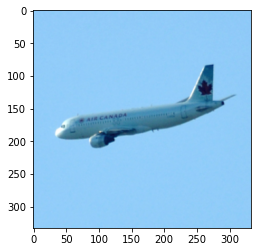

In [26]:
def read_img(filepath):
    image_stream = tf.io.read_file(filepath)
    image_decode = tf.image.decode_image(image_stream)
    # 將影像增加一個維度(number,height,width,channel)方便之後存入紀錄檔中
    # image_decode = tf.expand_dims(image_decode, axis=0)
    return image_decode
img = read_img("imgs/airplane.png")
plt.imshow(img)
plt.show()

with summary_writer.as_default():
    tf.summary.image("Airplane",[img], step=0)# 存入影像資訊   
    
    
### 一次存入五張影像    
img_files = ['airplane_zoom.png', 'airplane_flip.png', 'airplane_color.png', 'airplane_rot.png',
             'airplane.png']  # 創建一個陣列用來儲存讀入的影像 
imgs = []
for file in img_files: 
    imgs.append(read_img('imgs/'+file))  # 讀取影像並存入陣列中 

with summary_writer.as_default():  # summary_writer作為預設寫入的紀錄檔 
    # 一次存入五張影像(注意:如果max_outputs沒設定為5，就只會儲存3張影像) 
    tf.summary.image("Airplane Augmentation", imgs, max_outputs=5, step=0)
    
    
### 將五張影像以不同Step(時間)儲存
with summary_writer.as_default():  # summary_writer作為預設寫入的紀錄檔
    # 每次儲存一張影像，並儲存在不同Step中
    for i, img in enumerate(imgs):
        tf.summary.image("Save image each step", [img], step=i)

In [24]:
!dir "imgs"
# !ls image/

 磁碟區 C 中的磁碟是 Windows
 磁碟區序號:  604C-EF8A

 C:\Users\lucif\NLP\TensorFlowKerasPython\EasyLearnTensorflow 2.0\imgs 的目錄

2020/11/24  下午 04:21    <DIR>          .
2020/11/24  下午 04:21    <DIR>          ..
2020/11/24  下午 04:21           110,958 airplane.png
2020/11/23  上午 10:39            22,118 Functional_API_Multi_Input_Multi_Output_Model.png
2020/11/23  上午 03:04             6,233 Sequential_Model.png
               3 個檔案         139,309 位元組
               2 個目錄  101,321,379,840 位元組可用


### Text

In [27]:
# 建立一個陣列，裡面包含了對話記錄
texts = ["小明：Cubee小助理最近好想學深度學習的技術哦!", 
         "Cubee：這是當然的阿，這可現今最火的技術呢!", 
         "小明：那我該如何入門呢?", 
         "Cubee：推薦你一本書「輕鬆學會Google TensorFlow2.0深度學習」。", 
         "小明：這本書沒有深度學習經驗的人也能學會嗎?", 
         "Cubee：這是當然的，你只需要基礎Python能力就可以學會了!", 
         "小明：太好了那我要趕快去買了!"]

with summary_writer.as_default():  # summary_writer作為預設寫入的紀錄檔
    # 將每一段字串資訊以不同Step存入到記錄檔中
    for i, text in enumerate(texts):
        tf.summary.text("Chat record", text, step=i)

### Audio

In [28]:
# 建立讀取音訊的函數
def read_audio(file):
    audio_string = tf.io.read_file(file)  # 讀取檔案
    # 將讀入檔案以音訊格式來解碼
    audio, fs = tf.audio.decode_wav(audio_string)
    # 因為tf.summary.audio要求輸入格式為[k(clips), t(frames), c(channels)]
    # 而解碼後的音訊只有[t(frames), c(channels)]，所以需要增加一個維度給音訊
    audio = tf.expand_dims(audio, axis=0)
    return audio, fs

audio, fs = read_audio('data/audio/cat.wav')  # 讀取音訊檔

with summary_writer.as_default():  # summary_writer作為預設寫入的紀錄檔
    tf.summary.audio('cat', audio, fs, step=0)  # 存入音訊資訊

### 實驗一：使用tf.summary.image紀錄訓練結果

In [29]:
from preprocessing import parse_aug_fn, parse_fn

### Confusion matrix
Confusion matrix函數：透過tf.math.confusion_matrix來計算Confusion matrix

In [30]:
y_true = [2, 1, 0, 2, 2, 0, 1, 1]
y_pred = [0, 1, 0, 2, 2, 0, 2, 1]
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=3).numpy()
print(cm)

[[2 0 0]
 [0 2 1]
 [1 0 2]]


建立plot_confusion_matrix函式：將剛剛上方計算的Confusion matrix陣列以Matplotlib圖片來表示，而Confusion matrix中的數字改成百分比型式

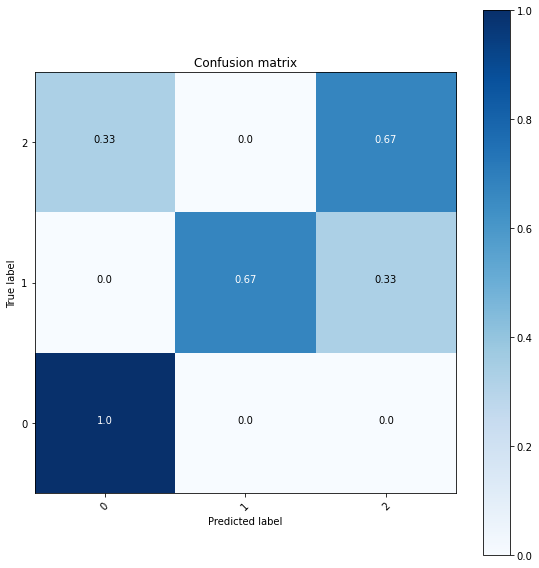

In [32]:
def plot_confusion_matrix(cm, class_names):
    """
    產生一張圖表示的Confusion matrix
    
    Args:
    cm (shape = [n, n]): 傳入Confusion matrix
    class_names (shape = [n]): 傳入類別
    """
    # 標準化confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    tick_index = np.arange(len(class_names))
    # matplotlib 3.1.1 bug，如果不設定ylim在[-0.5~2.5]，圖片y軸範圍會被縮小成[0~2]
    plt.ylim([-0.5, 2.5])
    # Y軸顯示類別名稱
    plt.yticks(tick_index, class_names)
    # X軸顯示類別名稱，並將類別名稱旋轉45度(避免文字重疊)
    plt.xticks(tick_index, class_names, rotation=45)
    # 再圖片右邊產生一條顏色刻度條
    plt.colorbar()

    # 在每一格Confusion matrix輸入預測百分比
    threshold = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # 如果格內背景顏色太深使用白色文字顯示，反之使用黑色文字
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
            
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # 將圖片的位置進行調整，避免x或y軸的文字被遮擋
    plt.tight_layout()
    return figure

# Example
img = plot_confusion_matrix(cm, [0, 1, 2])

建立plot_to_image函數：將Matplotlib圖片轉TensorFlow型式的圖片，這樣才能夠透過tf.summary.image紀錄影像到TensorBoard。

In [34]:
import io
def plot_to_image(figure):
    """將Matplotlib plot的圖片轉TensorFlow的張量格式"""
    # 將Matplotlib plot的圖片以PNG的格式儲存到記憶體中
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # 關閉plt圖片，防止圖片直接顯示在Jupyter notebook介面中
    plt.close(figure)
    buf.seek(0)
    # 將記憶體中的資料轉成TensorFlow格式
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

# Example
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=3).numpy()
img = plot_confusion_matrix(cm, [0, 1, 2])
img_show = plot_to_image(img)

### 創建Callback函數
創建回調函數：訓練過程中每個epoch結束，會產生一張Confusion matrix的圖片，並將圖片紀錄在Tensorboard上。

In [35]:
class ConfusionMatrix(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, test_data, class_name):
        super(ConfusionMatrix, self).__init__()
        self.log_dir = log_dir
        self.test_data = test_data
        self.class_names = class_name
        self.num_classes = len(class_name)

    def on_train_begin(self, logs=None):
        path = os.path.join(self.log_dir, 'confusion_matrix')
        # 創建TensorBoard紀錄檔
        self.writer = tf.summary.create_file_writer(path)

    def on_epoch_end(self, epoch, logs=None):
        # 計算Confusion matrix
        total_cm = np.zeros([10, 10])
        for x, y_true in self.test_data:
            y_pred = self.model.predict(x)
            y_pred = np.argmax(y_pred, axis=1)
            y_true = np.argmax(y_true, axis=1)
            cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes).numpy()
            total_cm += cm
        
        # 將Confusion matrix轉成Matplotlib圖片
        figure = plot_confusion_matrix(total_cm, class_names=self.class_names)
        # 將Matplotlib圖片轉成TensorFlow型式的圖片
        cm_image = plot_to_image(figure)

        # 將圖片紀錄在TensorBoard log中
        with self.writer.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [38]:
def data_normalize(train, test, scale=1):
    (x_train,y_train) = train
    (x_test,y_test) = test
    train_nums = x_train.shape[0] // scale
    test_nums = x_test.shape[0] // scale
    x_train, y_train = x_train[:train_nums], y_train[:train_nums]
    x_test, y_test = x_test[:test_nums], y_test[:test_nums]
   
    #x_train = parse_aug_fn(x_train)
    #x_test = parse_aug_fn(x_test)
    
    x_train = x_train.astype(np.float32) / 255.
    x_test = x_test.astype(np.float32) / 255. 
    #x_train = tf.reshape(x_train, shape=(-1,28*28))
    #x_test = tf.reshape(x_test, shape=(-1,28*28))
    y_train = utils.to_categorical(y_train).astype(np.int32)
    y_test = utils.to_categorical(y_test).astype(np.int32)
    print(x_train.shape,y_train.shape)
    print(x_test.shape,y_test.shape)
    
    return (x_train,y_train),(x_test,y_test)

(x_train,y_train),(x_test,y_test) = datasets.cifar10.load_data()
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
(x_train,y_train),(x_test,y_test) = data_normalize((x_train,y_train),(x_test,y_test),scale=10)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)
(5000, 32, 32, 3) (5000, 10)
(1000, 32, 32, 3) (1000, 10)


In [37]:
def build_CNN_model():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, 3, activation='relu', kernel_initializer='glorot_uniform')(inputs)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = layers.Conv2D(32, 3, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(10)(x)
    # 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
    model = models.Model(inputs, outputs, name='model-1')
    return model

model_1 = build_CNN_model()
model_1.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        18464     
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                1239

In [46]:
# 儲存訓練記錄檔
logs_dirs = 'models/lab7-logs-images'
os.makedirs(logs_dirs, exist_ok=True)
model_cbk = keras.callbacks.TensorBoard(logs_dirs)
# 儲存Confusion matrix圖片
save_cm = ConfusionMatrix(logs_dirs, zip(x_test,y_test), class_names)

model_1.compile(keras.optimizers.Adam(), 
                loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
                metrics=[keras.metrics.CategoricalAccuracy()])

In [47]:
epochs = 9
batch_size=64
history_1 = model_1.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.1,
                        verbose=2,
                        callbacks=[model_cbk, save_cm])

Train on 4500 samples, validate on 500 samples
Epoch 1/9


ProfilerNotRunningError: Cannot stop profiling. No profiler is running.